# Convolutional autoencoder for image denoising (畳み込み式オートエンコーダーによる画像のノイズ除去)

**Author:** [Santiago L. Valdarrama](https://twitter.com/svpino)<br>
**Date created:** 2021/03/01<br>
**Last modified:** 2021/03/01<br>
**Description:** How to train a deep convolutional autoencoder for image denoising.

## 序章

この例は、画像のノイズ除去のためにディープ畳み込みオートエンコーダーを実装し、MNISTデータセットからノイズの多い数字の画像をクリーンな数字の画像にマッピングする方法を示しています。この実装は 、[François Chollet](https://twitter.com/fchollet)による[Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)というタイトルの元のブログ投稿に基づいています。

## 設定

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## データを準備する

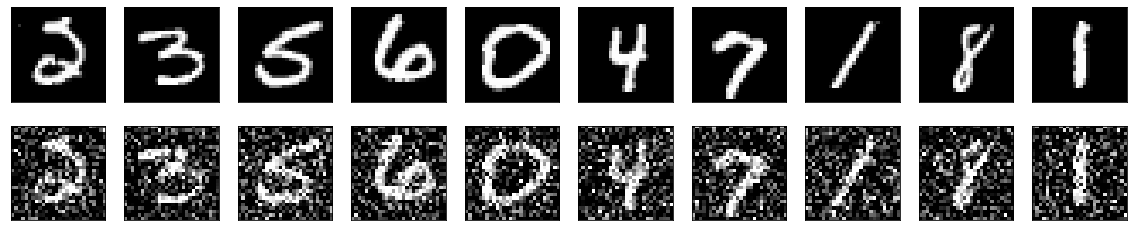

In [2]:
# Since we only need images from the dataset to encode and decode, we won't use the labels.
# 符号化と復号化に必要なのはデータセットの画像だけなので、ラベルは使いません。
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
# データの正規化と再形成
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
# ノイズを加えたデータのコピーを作成
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
# 学習データと、そのデータにノイズを加えたものを表示する
display(train_data, noisy_train_data)

## オートエンコーダーを構築する

Functional APIを使用して、畳み込みオートエンコーダーを構築します。

In [3]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        9248  

これで、`train_data`を入力データとターゲットの両方に使って、オートエンコーダーを学習することができます。
同じフォーマットで検証データを設定していることに注目してください。

In [4]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 [==============================] - 32s 64ms/step - loss: 0.1338 - val_loss: 0.0734
Epoch 2/50
469/469 [==============================] - 30s 64ms/step - loss: 0.0716 - val_loss: 0.0694
Epoch 3/50
469/469 [==============================] - 30s 64ms/step - loss: 0.0691 - val_loss: 0.0679
Epoch 4/50
469/469 [==============================] - 31s 67ms/step - loss: 0.0679 - val_loss: 0.0670
Epoch 5/50
469/469 [==============================] - 31s 66ms/step - loss: 0.0671 - val_loss: 0.0663
Epoch 6/50
469/469 [==============================] - 30s 65ms/step - loss: 0.0665 - val_loss: 0.0658
Epoch 7/50
469/469 [==============================] - 31s 65ms/step - loss: 0.0660 - val_loss: 0.0656
Epoch 8/50
469/469 [==============================] - 30s 65ms/step - loss: 0.0657 - val_loss: 0.0650
Epoch 9/50
469/469 [==============================] - 31s 65ms/step - loss: 0.0654 - val_loss: 0.0648
Epoch 10/50
469/469 [==============================] - 31s 66ms/step - loss: 0.065

テストデータセットで予測し、オートエンコーダーからの予測と一緒に元の画像を表示しましょう。

まったく同じではありませんが、予測が元の画像にかなり近いことに注意してください。

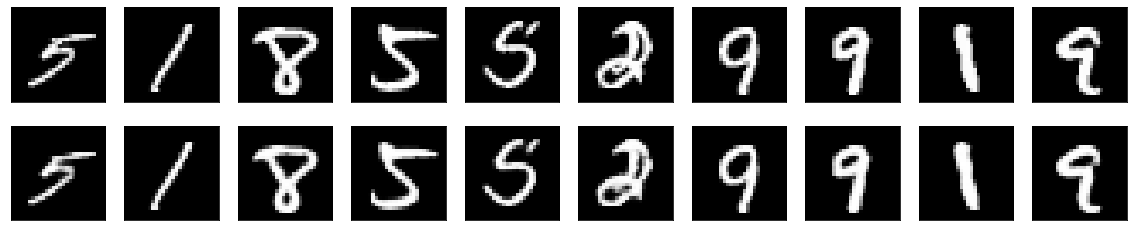

In [5]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

オートエンコーダーが動作することがわかったので、ノイズの多いデータを入力に、クリーンなデータをターゲットにして、オートエンコーダーを再学習してみましょう。このオートエンコーダーには 画像をノイズ除去する方法を学習させます。

In [6]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 [==============================] - 29s 63ms/step - loss: 0.1002 - val_loss: 0.0933
Epoch 2/100
469/469 [==============================] - 30s 63ms/step - loss: 0.0928 - val_loss: 0.0911
Epoch 3/100
469/469 [==============================] - 30s 64ms/step - loss: 0.0912 - val_loss: 0.0901
Epoch 4/100
469/469 [==============================] - 31s 66ms/step - loss: 0.0902 - val_loss: 0.0892
Epoch 5/100
469/469 [==============================] - 31s 65ms/step - loss: 0.0895 - val_loss: 0.0885
Epoch 6/100
469/469 [==============================] - 30s 64ms/step - loss: 0.0890 - val_loss: 0.0882
Epoch 7/100
469/469 [==============================] - 30s 64ms/step - loss: 0.0885 - val_loss: 0.0878
Epoch 8/100
469/469 [==============================] - 31s 66ms/step - loss: 0.0881 - val_loss: 0.0874
Epoch 9/100
469/469 [==============================] - 31s 66ms/step - loss: 0.0878 - val_loss: 0.0870
Epoch 10/100
469/469 [==============================] - 31s 66ms/step - l

それでは、ノイズの多いデータを予測して、オートエンコーダーの結果を表示してみましょう。

オートエンコーダーは、入力画像からノイズを見事に除去していることがわかります。驚くべき仕事をしています。

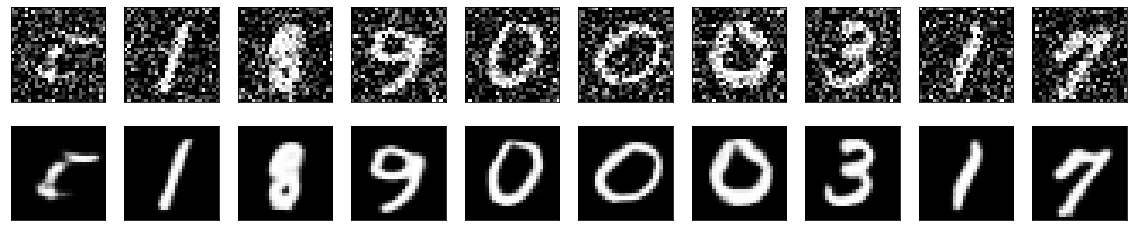

In [7]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)